In [14]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from imblearn.under_sampling import NearMiss 
import imblearn
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score,\
classification_report, log_loss
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

pd.set_option("max_columns",90, "max_rows", 90)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
# read data
raw_df = pd.read_csv('Gse_panel_current_sample_raw.csv')

In [16]:
def model_fit(clf, X_train, X_test, y_train, y_test, display=False):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    if display:
        print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

        # ROC - AUC  
        conf_score = clf.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
        fpr, tpr, _ = roc_curve(y_test, conf_score)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC - LR')
        plt.legend(loc="lower right")
        plt.show()

        # PR AUC  
        conf_score = clf.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
        precision, recall, _ = precision_recall_curve(y_test, conf_score)
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall(True Positive Rate)')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

        # cohen's kappa: how well the classifier performed as compared to how well it would have performed simply by chance
        print("cohen's kappa: ", cohen_kappa_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
    return y_pred

In [17]:
def data_prep(raw_df):
    #################################################
    #                 missing data                  #
    #################################################
    # fill in the missing msa
    # missing msa --> corresponding prop_state x
    # prop_state x --> find the most frequent msa in that state ==> sta_msa, a dict {state_name: most frequent msa in that state}
    # use sta_msa to fill in the missing msa
    sta_msa = {}
    for state, group in raw_df[['prop_state', 'msa']].groupby('prop_state'):
        sta_msa[state] = group['msa'].value_counts().idxmax()
    raw_df['msa'] = raw_df[['prop_state', 'msa']].apply(lambda row: sta_msa[row['prop_state']] if np.isnan(row['msa']) else row['msa'], axis = 1)

    # fill in the missing num_bo and num_unit with their median respectively 
    raw_df['num_bo'].fillna(raw_df['num_bo'].median(), inplace=True)
    raw_df['num_unit'].fillna(raw_df['num_unit'].median(), inplace=True)

    # drop the training sample with missing data in status column
    df = raw_df.dropna(how='any').copy()
    
    df['status'] = df['status'].apply(lambda x: int(x=='D60-D90'))
    
    X = df.drop(['loan_id', 'status', 'status_prev'], axis=1).copy()
    X.drop(['prop_state'], axis=1, inplace=True)
#   X.drop(['prop_state', 'oltv', 'oyr', 'orig_rt', 'orig_upb', 'avg_upb', 'year', 'oqtr'], axis=1, inplace=True)
#   golden_features = ['fico', 'ur', 'CLTV', 'dti', 'loan_age_qtr', 'HPI_O']
#   X = X[golden_features]
#   X.drop(['pmms_o', 'HPI'], axis=1, inplace=True)
#   X.drop(['loan_purp', 'fhb_flag', 'occ_stat', 'prop_type'], axis=1, inplace=True)
    X = pd.get_dummies(X)
    
    # perform log transformation for the highly skewed features
    X_num = X.select_dtypes(include=['float64', 'int64'])
    skewed_feat = X_num.skew()
    skewed_idx = skewed_feat[skewed_feat.abs() > 2].index
    X[skewed_idx] = X[skewed_idx].transform(np.log)

    # feature engineering
#    X['HPI_diff'] = X['HPI'] - X['HPI_O']
#    X['PMMS_diff'] = X['PMMS'] - X['pmms_o']
#    X['LTV_diff'] = X['CLTV'] - X['oltv']
#    X['dti_CLTV'] = X['dti'] * X['CLTV']
#    X['fico'] = X['fico']**2
    
    y = df['status'].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    return (X_train, X_test, y_train, y_test)

## Under-sampling

In [18]:
def under_sample(data, times):
    pos_idx= np.array(data[data.status==1].index)
    neg_idx = np.array(data[data.status==0].index)
    
    #times denote the normal data = times*fraud data
    pos_count = len(pos_idx)
    neg_idx_us = np.array(np.random.choice(neg_idx, (times*pos_count), replace=False))
    us_data= np.concatenate([pos_idx, neg_idx_us])
    us_data = data.loc[us_data,:].copy()   
    
    #print("the normal transacation proportion is :",len(us_data[us_data.status==0])/len(us_data))
    #print("the fraud transacation proportion is :",len(us_data[us_data.status==1])/len(us_data))
    #print("total number of record in resampled data is:",len(us_data))
    return (us_data)

In [19]:
# split sample set
X_train, X_test, y_train, y_test = data_prep(raw_df)
X_train = X_train.values
y_train = y_train.values

### Logistic Regression

Accuracy = 0.7944025834230355


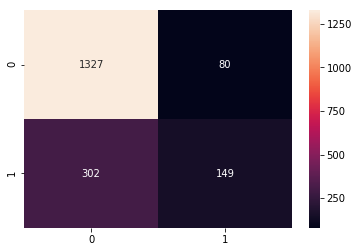

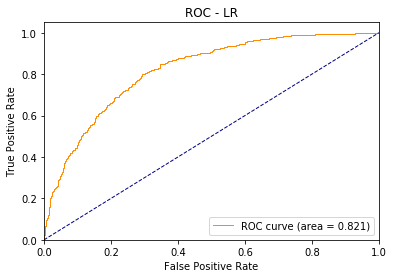

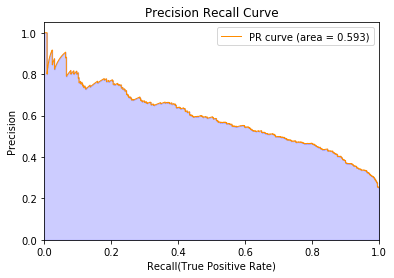

cohen's kappa:  0.3284434780798613
             precision    recall  f1-score   support

          0       0.81      0.94      0.87      1407
          1       0.65      0.33      0.44       451

avg / total       0.77      0.79      0.77      1858



In [20]:
df_train = pd.concat([X_train, y_train], axis=1)

# print('-'*35, i, '-'*35)

# under-sampling
us_df_train = under_sample(df_train, 3)
us_X_train = us_df_train.drop(['status'], axis=1).copy()
us_y_train = us_df_train['status'].copy()

# split 
us_X_train_sub, us_X_test_sub, us_y_train_sub, us_y_test_sub = train_test_split(us_X_train, us_y_train, test_size=0.3, random_state=1)

# train and predict
clf = linear_model.LogisticRegression()
y_pred = model_fit(clf, us_X_train_sub, us_X_test_sub, us_y_train_sub, us_y_test_sub, display=True)

### GBT

In [ ]:
gb = GradientBoostingClassifier(random_state=10)
model_fit(gb, X_train, y_train)

### Tuning HP of logistic regression via RandomizedSearchCV

In [10]:
params_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
hp = RandomizedSearchCV(linear_model.LogisticRegression(), params_grid, n_iter=4, refit=True, scoring='roc_auc', cv=5)
hp.fit(X_train, y_train)
hp.grid_scores_, hp.best_params_, hp.best_score_

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81110, std: 0.01170, params: {'penalty': 'l2', 'C': 100},
  mean: 0.81212, std: 0.01095, params: {'penalty': 'l2', 'C': 1},
  mean: 0.85472, std: 0.00676, params: {'penalty': 'l1', 'C': 1000},
  mean: 0.85283, std: 0.00781, params: {'penalty': 'l1', 'C': 1}],
 {'penalty': 'l1', 'C': 1000},
 0.8547151853558419)

### Tuning HP of gradient boost via RandomizedSearchCV

In [11]:
tic = time.time()  # 8698 secs
params_grid = {'n_estimators': list(range(20, 101, 10)), 'max_depth': list(range(2, 16, 2)), 
          'min_samples_split': list(range(600, 1601, 200)), 'min_samples_leaf': list(range(30, 71, 10)), 
          'max_features': list(range(7,30,2))}
hp = RandomizedSearchCV(GradientBoostingClassifier(learning_rate=0.1), params_grid, n_iter=12, refit=True, n_jobs=4, scoring='f1')
hp.fit(X_train, y_train)
toc = time.time()
print(f"Time cost: {toc-tic} seconds")
hp.grid_scores_, hp.best_params_, hp.best_score_

Time cost: 8698.89240026474 seconds


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Tuning HP of AdaBoost via RandomizedSearchCV

In [12]:
tic = time.time()  # 1727 secs
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth": list(range(2, 16, 2)),
              "base_estimator__min_samples_split": list(range(600, 1601, 200)),
              "base_estimator__min_samples_leaf": list(range(30, 71, 10)),
              "n_estimators": list(range(20, 101, 10))
             }
base_clf = DecisionTreeClassifier(random_state=11, max_features="auto")
clf = AdaBoostClassifier(base_clf, learning_rate=1)
hp = RandomizedSearchCV(clf, param_grid, n_iter=12, refit=True, n_jobs=4, scoring='f1')
hp.fit(X_train, y_train)
toc = time.time()
print(f"Time cost: {toc-tic} seconds")
hp.grid_scores_, hp.best_params_, hp.best_score_

Time cost: 1727.8443999290466 seconds


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [13]:
hp.grid_scores_, hp.best_params_, hp.best_score_

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.01111, std: 0.00270, params: {'n_estimators': 90, 'base_estimator__splitter': 'random', 'base_estimator__min_samples_split': 1200, 'base_estimator__min_samples_leaf': 70, 'base_estimator__max_depth': 8, 'base_estimator__criterion': 'entropy'},
  mean: 0.00251, std: 0.00355, params: {'n_estimators': 30, 'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 1600, 'base_estimator__min_samples_leaf': 60, 'base_estimator__max_depth': 4, 'base_estimator__criterion': 'gini'},
  mean: 0.00000, std: 0.00000, params: {'n_estimators': 30, 'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 1600, 'base_estimator__min_samples_leaf': 30, 'base_estimator__max_depth': 2, 'base_estimator__criterion': 'entropy'},
  mean: 0.00296, std: 0.00237, params: {'n_estimators': 30, 'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 1200, 'base_estimator__min_samples_leaf': 50, 'base_estimator__max_depth': 8, 'base_estimator__criterion': 'entr

### Majority Voter

In [123]:
X_train, X_test, y_train, y_test = data_prep(raw_df)

df_train = pd.concat([X_train, y_train], axis=1)

y_pred_stacker = []
for i in range(400):
    print(i)
    # under-sampling
    us_df_train = under_sample(df_train, 3)
    us_X_train = us_df_train.drop(['status'], axis=1).copy()
    us_y_train = us_df_train['status'].copy()

    # split 
    us_X_train_sub, us_X_test_sub, us_y_train_sub, us_y_test_sub = train_test_split(us_X_train, us_y_train, test_size=0.3, random_state=1)

    # train and predict
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, 
                                     subsample=0.75, min_samples_split=800, min_samples_leaf=50,
                                     max_depth=4, max_features=19, random_state=0, verbose=0)
    y_pred = model_fit(clf, us_X_train_sub, X_test, us_y_train_sub, y_test, display=False)
    y_pred_stacker.append(y_pred)


y_pred_stacker = np.array(y_pred_stacker)
y_pred_maj = stats.mode(y_pred_stacker)

print(f"Accuracy = {accuracy_score(y_test, y_pred_maj.mode[0])}")
print("cohen's kappa: ", cohen_kappa_score(y_test, y_pred_maj.mode[0]))
print(classification_report(y_test, y_pred_maj.mode[0]))
print(log_loss(y_test, y_pred_maj.mode[0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Classifer Test

----------------------------------- KNeighborsClassifier -----------------------------------
Accuracy = 0.9312857223699847


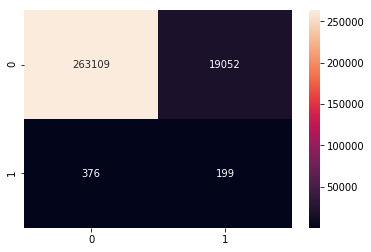

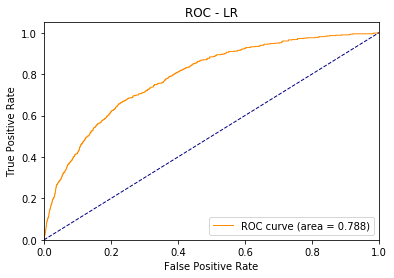

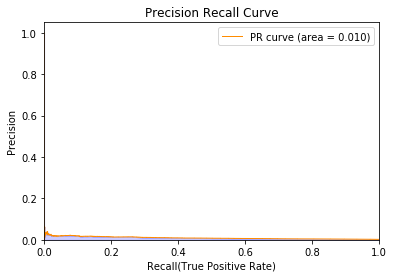

cohen's kappa:  0.016189152883045455
             precision    recall  f1-score   support

          0       1.00      0.93      0.96    282161
          1       0.01      0.35      0.02       575

avg / total       1.00      0.93      0.96    282736

----------------------------------- SVC -----------------------------------
Accuracy = 0.9304934638673533


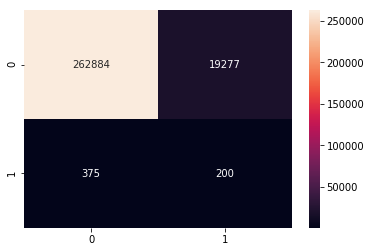

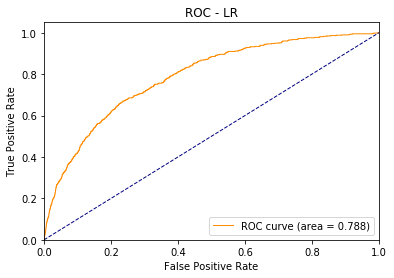

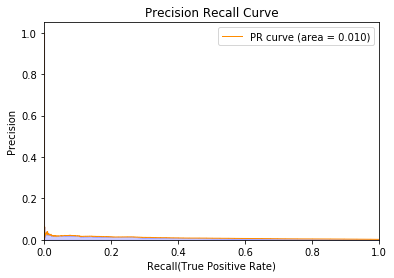

cohen's kappa:  0.016060823269904434
             precision    recall  f1-score   support

          0       1.00      0.93      0.96    282161
          1       0.01      0.35      0.02       575

avg / total       1.00      0.93      0.96    282736

----------------------------------- NuSVC -----------------------------------
Accuracy = 0.9340657008658254


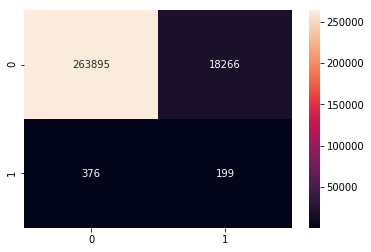

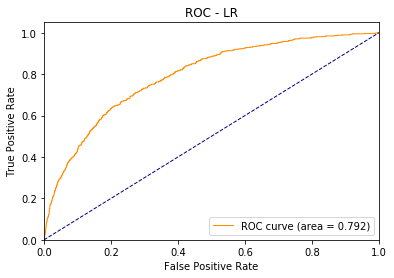

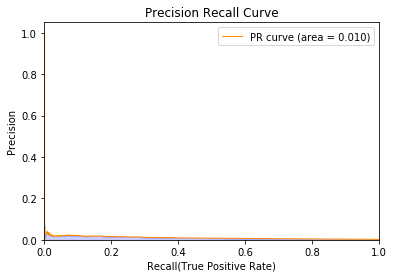

cohen's kappa:  0.01702595649880878
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.35      0.02       575

avg / total       1.00      0.93      0.96    282736

----------------------------------- DecisionTreeClassifier -----------------------------------
Accuracy = 0.9359720728877823


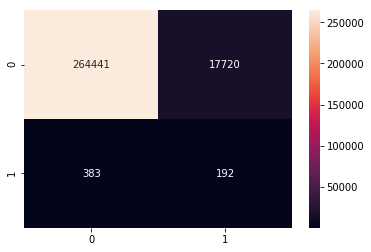

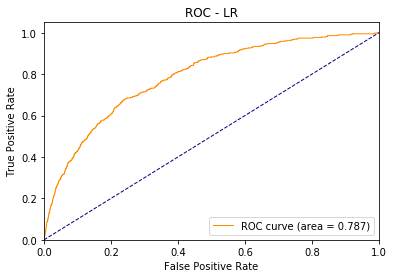

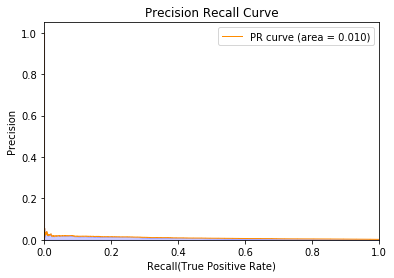

cohen's kappa:  0.016897051753057002
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.33      0.02       575

avg / total       1.00      0.94      0.96    282736

----------------------------------- RandomForestClassifier -----------------------------------
Accuracy = 0.9328384075604097


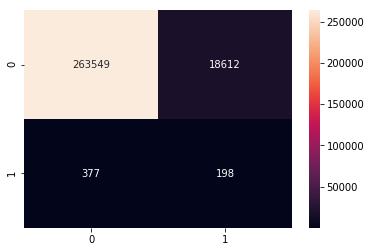

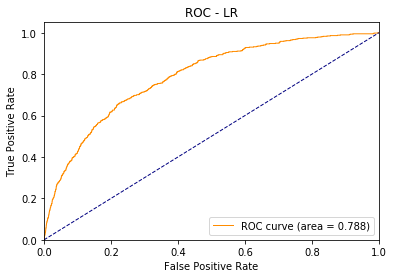

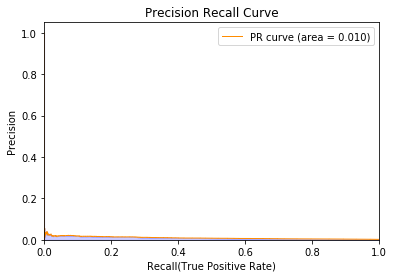

cohen's kappa:  0.016546720954757954
             precision    recall  f1-score   support

          0       1.00      0.93      0.97    282161
          1       0.01      0.34      0.02       575

avg / total       1.00      0.93      0.96    282736

----------------------------------- AdaBoostClassifier -----------------------------------
Accuracy = 0.9411288268915172


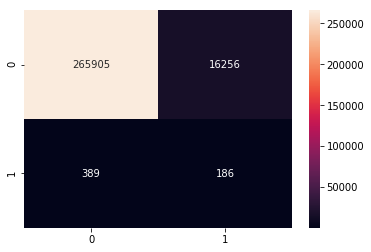

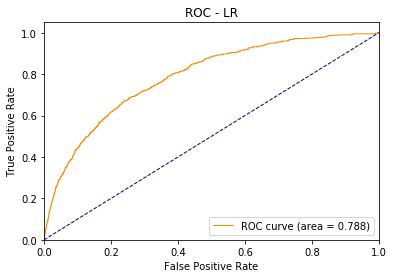

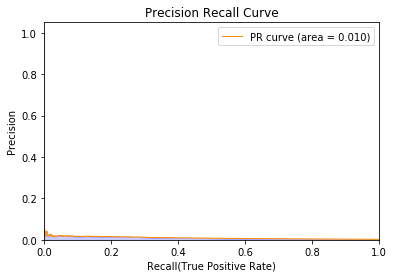

cohen's kappa:  0.01800127455366518
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.32      0.02       575

avg / total       1.00      0.94      0.97    282736

----------------------------------- GradientBoostingClassifier -----------------------------------
Accuracy = 0.9361772112500707


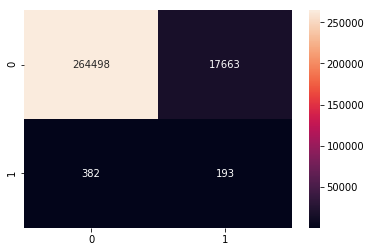

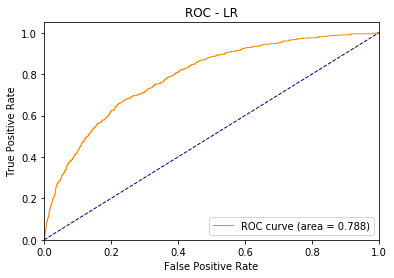

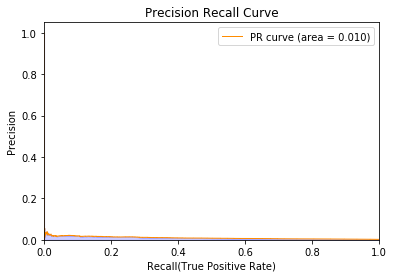

cohen's kappa:  0.017069733754024985
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.34      0.02       575

avg / total       1.00      0.94      0.97    282736

----------------------------------- GaussianNB -----------------------------------
Accuracy = 0.9456029653103956


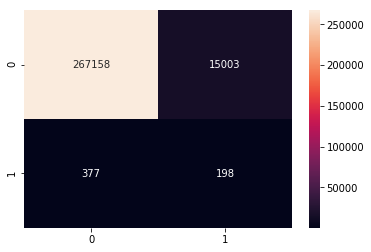

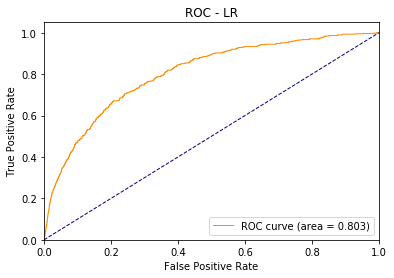

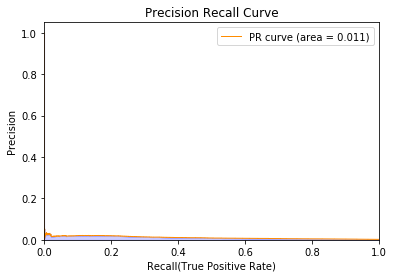

cohen's kappa:  0.021265612061889927
             precision    recall  f1-score   support

          0       1.00      0.95      0.97    282161
          1       0.01      0.34      0.03       575

avg / total       1.00      0.95      0.97    282736

----------------------------------- LinearDiscriminantAnalysis -----------------------------------
Accuracy = 0.9375282949465226


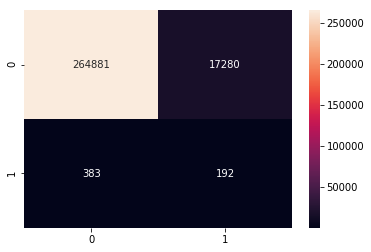

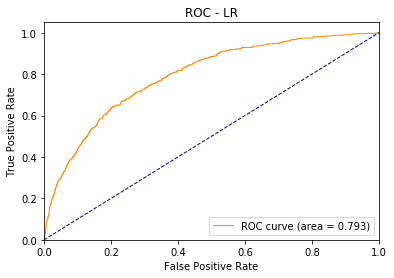

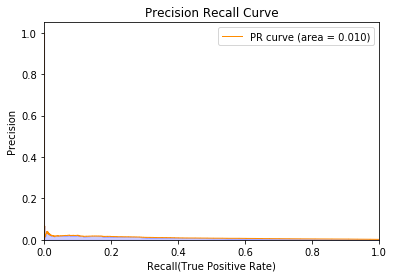

cohen's kappa:  0.017408519920922294
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.33      0.02       575

avg / total       1.00      0.94      0.97    282736

----------------------------------- QuadraticDiscriminantAnalysis -----------------------------------
Accuracy = 0.9359897572293588


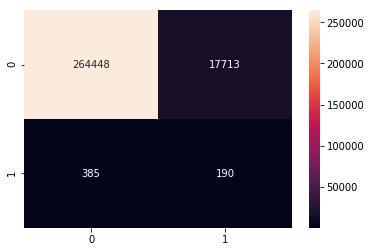

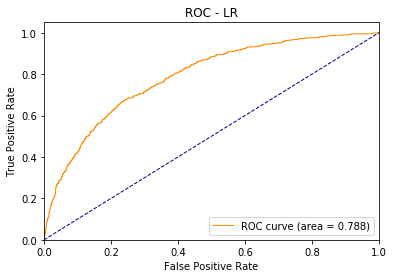

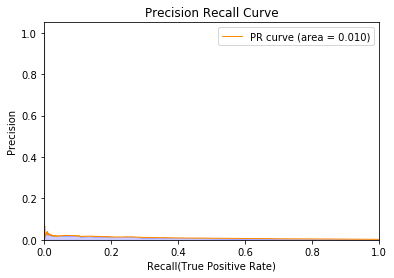

cohen's kappa:  0.016689939504866858
             precision    recall  f1-score   support

          0       1.00      0.94      0.97    282161
          1       0.01      0.33      0.02       575

avg / total       1.00      0.94      0.96    282736



In [118]:
X_train, X_test, y_train, y_test = data_prep(raw_df)

df_train = pd.concat([X_train, y_train], axis=1)

clf_list = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for clf in clf_list:
    print('-'*35, clf.__class__.__name__, '-'*35)
    # under-sampling
    us_df_train = under_sample(df_train, 3)
    us_X_train = us_df_train.drop(['status'], axis=1).copy()
    us_y_train = us_df_train['status'].copy()

    # split 
    us_X_train_sub, us_X_test_sub, us_y_train_sub, us_y_test_sub = train_test_split(us_X_train, us_y_train, test_size=0.3, random_state=1)

    # train and predict
    clf = linear_model.LogisticRegression()
    y_pred = model_fit(clf, us_X_train_sub, X_test, us_y_train_sub, y_test, display=True)